<a href="https://colab.research.google.com/github/apssouza22/cnn-for-devs/blob/master/f-image-interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image interpolation with Autoencoders
======


We are going to learn how to work with autoencoders to generate Latent Space/ feature map and from there do some nice things

Autoencoder Definition
-----------------------
AutoEncoder is an unsupervised Artificial Neural Network that attempts to encode the data by compressing it into the lower dimensions(dimensionality reduction) and then decoding the data to reconstruct the original input.

<img src="https://miro.medium.com/max/700/1*AJ_zWZundfZ2-11eZUw5GA.png">

In [1]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

Parameter Settings
-------------------


In [2]:
num_classes = 3
num_epochs = 30
batch_size = 128
learning_rate = 0.001
use_gpu = True
img_size = 64


MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We normalize and center them around 0, which gives a slight performance boost during training.
We create both a training set and a test set.

In [3]:
# import torchvision.transforms as transforms
# from torch.utils.data import DataLoader
# from torchvision.datasets import MNIST

# img_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])

# train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# full_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
# full_dataloader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)


In [4]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

# transform 정의 : Resize 후 Tensor 형태로
transform = transforms.Compose([
                                transforms.Resize((img_size,img_size)),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
])

dataset = ImageFolder(root = 'Data/', transform = transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


Autoencoder consists of an Encoder and a Decoder model

In [5]:
# Model responsible for generating our Latent space.
#Latent space, Typically it is a 100-dimensional hypersphere with each variable drawn from a Gaussian distribution with a mean of zero and a standard deviation of one
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # 64-4 60//2 31 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=img_size, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=img_size, out_channels=img_size*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc = nn.Linear(in_features=img_size * 2 * 7 * 7, out_features=num_classes)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.fc(x)
        return x

# Model responsible for reconstruct the image form our Latent space.
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(in_features=num_classes, out_features=img_size*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=img_size * 2, out_channels=img_size, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=img_size, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), img_size * 2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.tanh(self.conv1(x)) # last layer before output is tanh, since the images are normalized and 0-centered
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder = Autoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
autoencoder = autoencoder.to(device)

#The model’s parameters that need to be trained.
num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 308356


Train Autoencoder
--------

In [6]:
if not os.path.exists("assets"):
    os.mkdir("assets")

ENCODER_MODEL_PATH="assets/encoder.pth"
DECODER_MODEL_PATH="assets/decoder.pth"

optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
autoencoder.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in dataloader:
        print(image_batch.shape)
        image_batch = image_batch.to(device)
        image_batch_recon = autoencoder(image_batch)
      
        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
    
    torch.save(autoencoder.encoder.state_dict(), ENCODER_MODEL_PATH)
    torch.save(autoencoder.decoder.state_dict(), DECODER_MODEL_PATH)

    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
torch.Size([128, 1, 64, 64])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (262144x16 and 6272x3)

Plot Training Curve
--------------------

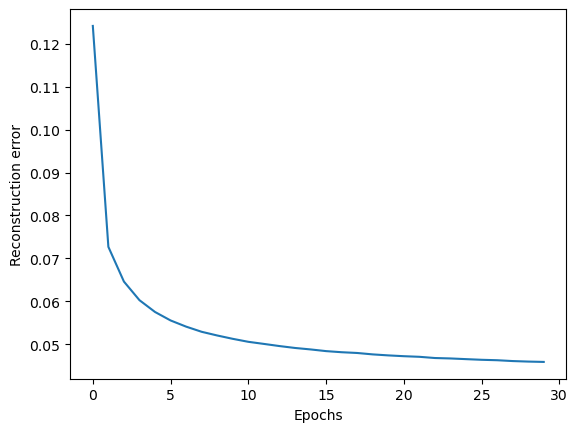

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

Evaluate on the Test Set
-------------------------

In [ ]:
# set to evaluation mode
autoencoder.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
    
    with torch.no_grad():

        image_batch = image_batch.to(device)
        print(image_batch.shape)

        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch)

        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([12

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils
plt.ion()

# Util function to display the images
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):
    with torch.no_grad():

        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()


Visualize Reconstructions
--------------------------

Original images


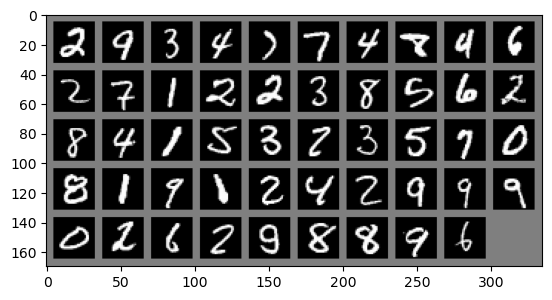

Autoencoder reconstruction:


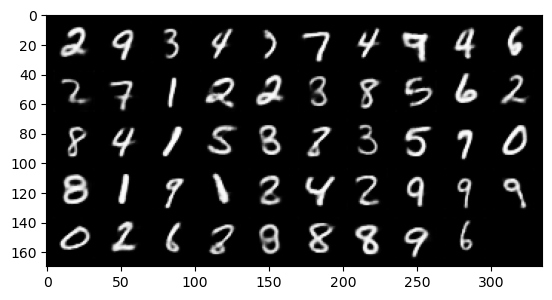

In [ ]:
autoencoder.eval()

images, labels = next(iter(test_dataloader))
# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the autoencoder
print('Autoencoder reconstruction:')
visualise_output(images, autoencoder)

In [ ]:
# Group all digits in a map ditits[i]=[...]
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])

    if sum(len(d) for d in digits) >= 1000:
        break;


## Practice Part


NameError: name 'dataloader' is not defined

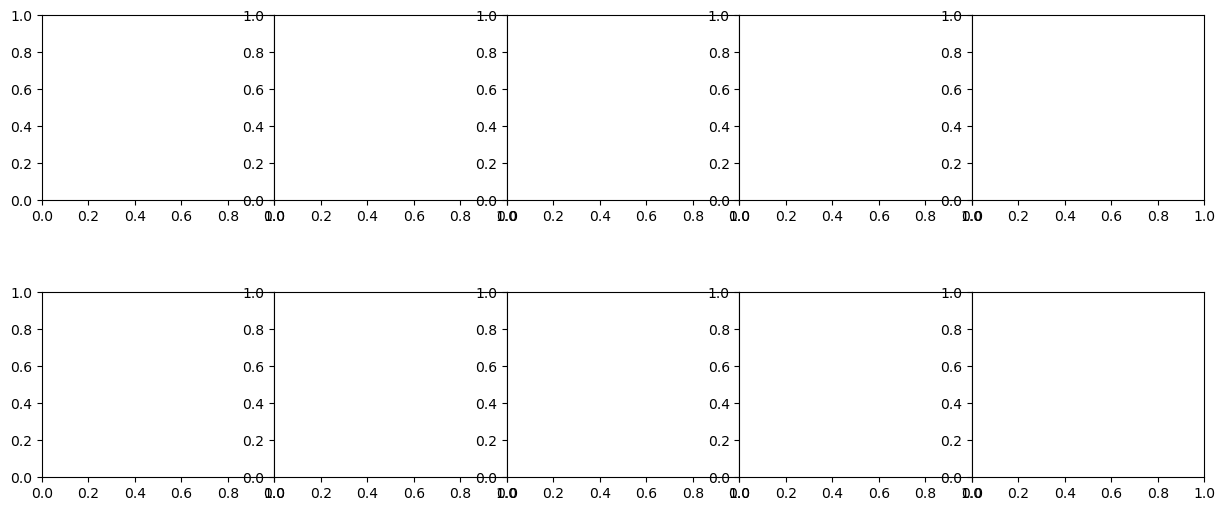

In [ ]:
autoencoder.eval()

def interpolation(lambda1, model, img1, img2):
    with torch.no_grad():
        # latent vector of first image
        img1 = img1.to(device)
        latent_1 = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2 = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = (1-lambda1) * latent_1 + lambda1 * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()
    
    return inter_image
    

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
# We start off by taking two images from the dataset, and linearly interpolate between them
for ind,l in enumerate(lambda_range):
    inter_image = interpolation(float(l), autoencoder, digits[7][0], digits[1][0])
    inter_image = to_img(inter_image)
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))

plt.show() 

Interpolate in Latent Space
----------------------------

The latent representation of autoencoders have been studied in the context of enabling interpolation between data points by decoding convex combinations of latent vectors

<img src="https://miro.medium.com/max/480/1*vEZE5VcjUr5RUbt_OWfR_w.gif">

In [ ]:
autoencoder.eval()

def interpolation(lambda1, model, img1, img2):
    with torch.no_grad():
        # latent vector of first image
        img1 = img1.to(device)
        latent_1 = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2 = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = (1-lambda1) * latent_1 + lambda1 * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()
    
    return inter_image
    

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
# We start off by taking two images from the dataset, and linearly interpolate between them
for ind,l in enumerate(lambda_range):
    inter_image = interpolation(float(l), autoencoder, digits[7][0], digits[1][0])
    inter_image = to_img(inter_image)
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))

plt.show() 

Random Latent Vector - generating random images
-------------------------------------------------

Typically, new images are generated using random points in the latent space. Taken a step further, points in the latent space can be constructed (e.g. all 0s, all 0.5s, or all 1s) and used as input or a query to generate a specific image.

We are going to transform our latent space by using simple vector arithmetic to create new points in the latent space that, in turn, can be used to generate images. This is an interesting idea, as it allows for the intuitive and targeted generation of images.


In [ ]:
autoencoder.eval()

with torch.no_grad():
    # approx. fit a multivariate Normal distribution (with diagonal cov.) to the latent vectors of a random part of the test set
    images, labels = next(iter(test_dataloader))
    images = images.to(device)
    latent = autoencoder.encoder(images)
    latent = latent.cpu()

    # Finding the mean and standard deviation from our latent space
    mean = latent.mean(dim=0)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()

    # sample latent vectors from the normal distribution
    latent = torch.randn(latent.shape[0], latent.shape[1])*std + mean

    # reconstruct images from the latent vectors
    latent = latent.to(device)
    img_recon = autoencoder.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()

In [ ]:
 latent = torch.randn(128, num_classes)*std + mean
 latent